In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, plot_confusion_matrix
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading data
data = pd.read_csv('./data/spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# Drop redundant columns
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# Rename columns to meaningful names
data.columns = ['label', 'text']
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


## Data Exploration

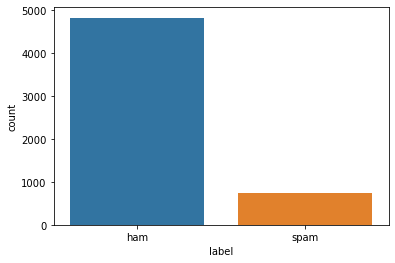

In [6]:
# plot and check data is balanced
sns.countplot(x='label', data=data)
plt.show()

*From the above countplot the data imbalance is quite evident.*

### Feature Engineering

For the purpose of data exploration, I am creating new features

 - char_count: Number of characters in the text message
 - word_count: Number of words in the text message
 - sent_count: Number of sentences in the text messag

In [7]:
# Add column of number of characters, words and sentences in each SMS
data['char_count'] = data['text'].apply(len)
data['word_count'] = data.apply(lambda row: nltk.word_tokenize(row["text"]), axis=1).apply(len)
data['sent_count'] = data.apply(lambda row: nltk.sent_tokenize(row["text"]), axis=1).apply(len)

data.describe().T

,count,mean,std,min,25%,50%,75%,max
char_count,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
word_count,5572.0,18.695621,13.742587,1.0,9.0,15.0,27.0,220.0
sent_count,5572.0,1.970747,1.417778,1.0,1.0,1.0,2.0,28.0


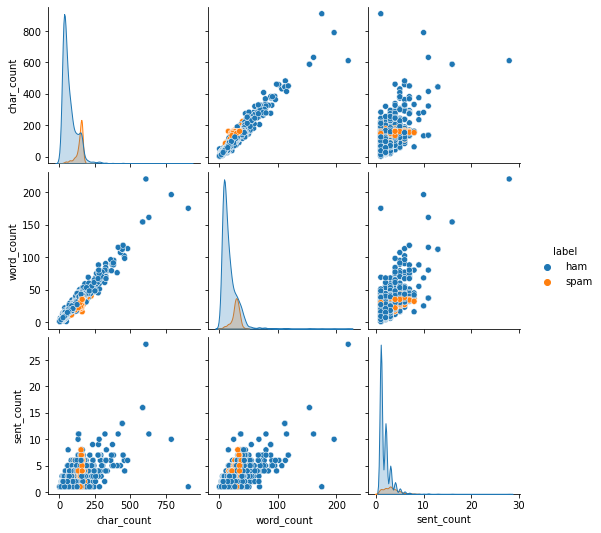

In [8]:
# plot pairplot of data
sns.pairplot(data, hue='label')
plt.show()

*From the pair plot, we can see a few outliers all in the class ham. This is interesting as we could put a cap over one of these. As they essentially indicate the same thing ie the length of SMS.*

### Outlier Detection

In [9]:
# Drop outliers
data = data[data['char_count'] < 350]
data.shape

(5548, 5)

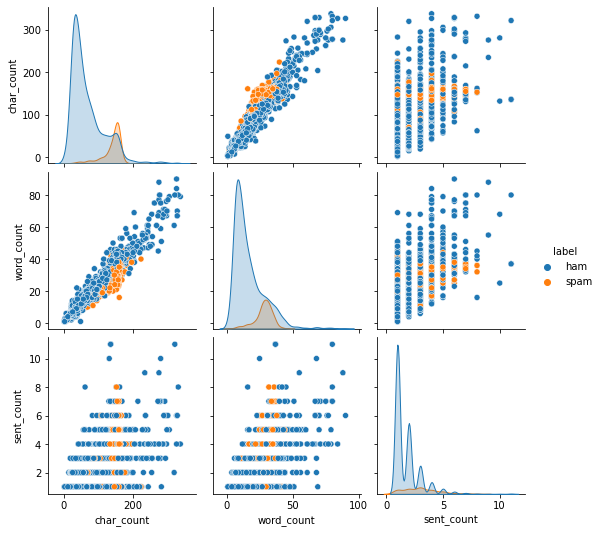

In [10]:
# plot pairplot of data
sns.pairplot(data, hue='label')
plt.show()

## Data Preprocessing

### Cleaning Text

In [11]:
# Look at a sample of data text before cleaning
data.sample(5)

,label,text,char_count,word_count,sent_count
920,ham,When u wana see it then,23,6,1
114,ham,"Wa, ur openin sentence very formal... Anyway, ...",143,34,3
4873,ham,Wat happened to the cruise thing,32,6,1
2184,ham,I know a few people I can hit up and fuck to t...,52,14,1
4522,ham,Actually I decided I was too hungry so I haven...,60,15,1


In [12]:
# Function to clean data
def clean_text(text):
    # remove non-alphabitic characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # convert to lowercase
    text = text.lower()
    # remove stopwords
    text = text.split()
    text = [word for word in text if word not in stopwords.words('english')]
    # stem words
    text = ' '.join(text)
    return text

data['clean_text'] = data['text'].apply(clean_text)
data.head()

,label,text,char_count,word_count,sent_count,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goes usf lives around though


### Tokenization

In [13]:
# Tokenize the text
data['clean_text'] = data['clean_text'].apply(nltk.word_tokenize)
data.head()

,label,text,char_count,word_count,sent_count,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,29,8,2,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,49,13,1,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,"[nah, think, goes, usf, lives, around, though]"


### Lemmatization

In [14]:
# Lemmatize the text
lemmatizer = WordNetLemmatizer()
data['clean_text'] = data['clean_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
data.head()

,label,text,char_count,word_count,sent_count,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,29,8,2,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,49,13,1,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,"[nah, think, go, usf, life, around, though]"


## Vectorize

In [15]:
' '.join(data['clean_text'][0])

'go jurong point crazy available bugis n great world la e buffet cine got amore wat'

In [16]:
# Create a corpus of text feature to encode further into vectorized form
corpus = []
for i in data['clean_text']:
    text = ' '.join([row for row in i])
    corpus.append(text)

In [17]:
# Changing text to vectorized form
vectorizer = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(corpus).toarray()
X.dtype

dtype('float64')

In [18]:
# Label encode
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['label'])
y.dtype

dtype('int32')

## Model Building

In [19]:
# Spliting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Testing on the following Classifiers
classifiers = [
    MultinomialNB(),
    RandomForestClassifier(n_estimators=100, random_state=42),
    KNeighborsClassifier(n_neighbors=5),
    SVC(kernel='linear')
]

for cls in classifiers:
    cls.fit(X_train, y_train)

# Dictionary of pipeline and classifier name for ease of reference
pipeline_dict = { 0: 'Multinomial Naive Bayes',
                    1: 'Random Forest',
                    2: 'K-Nearest Neighbors',
                    3: 'Support Vector Machine'
                }

In [21]:
# Cross validation
for i, cls in enumerate(classifiers):
    scores = cross_val_score(cls, X_train, y_train, cv=10, scoring='accuracy')
    print('\nClassifier: {}'.format(pipeline_dict[i]))
    print('Cross Validation Accuracy: {}'.format(scores.mean()))
    print('Cross Validation Standard Deviation: {}'.format(scores.std()))
    print('\n')


Classifier: Multinomial Naive Bayes
Cross Validation Accuracy: 0.9772410672523539
Cross Validation Standard Deviation: 0.005832930385818245



Classifier: Random Forest
Cross Validation Accuracy: 0.9815223801679783
Cross Validation Standard Deviation: 0.005315593490690082



Classifier: K-Nearest Neighbors
Cross Validation Accuracy: 0.9238428609196104
Cross Validation Standard Deviation: 0.009788409327830672



Classifier: Support Vector Machine
Cross Validation Accuracy: 0.9840013828727148
Cross Validation Standard Deviation: 0.002751972689804341




## Evaluating Models

In [22]:
# Model Evaluation
# Creating lists of varios classifiers and their respective scores
percision_list = []
recall_list = []
f1_list = []
trainset_accuracy_list = []
testset_accuracy_list = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = precision_score(y_test, pred_test)
    recall = recall_score(y_test, pred_test)
    f1 = f1_score(y_test, pred_test)
    train_acc = accuracy_score(y_train, pred_train)
    test_acc = accuracy_score(y_test, pred_test)

    percision_list.append(prec)
    recall_list.append(recall)
    f1_list.append(f1)
    trainset_accuracy_list.append(train_acc)
    testset_accuracy_list.append(test_acc)


In [23]:
# Initializing data of lists
data = {
    'Percision': percision_list,
    'Recall': recall_list,
    'F1': f1_list,
    'Train Set Accuracy': trainset_accuracy_list,
    'Test Set Accuracy': testset_accuracy_list
}

# Creating dataframe from data
results = pd.DataFrame(data, index=pipeline_dict.values())

In [24]:
results.style.background_gradient(cmap='summer_r')

,Percision,Recall,F1,Train Set Accuracy,Test Set Accuracy
Multinomial Naive Bayes,0.991453,0.852941,0.916996,0.981749,0.981081
Random Forest,0.991150,0.823529,0.899598,0.999324,0.977477
K-Nearest Neighbors,0.966667,0.426471,0.591837,0.941415,0.927928
Support Vector Machine,0.983471,0.875000,0.926070,0.991212,0.982883


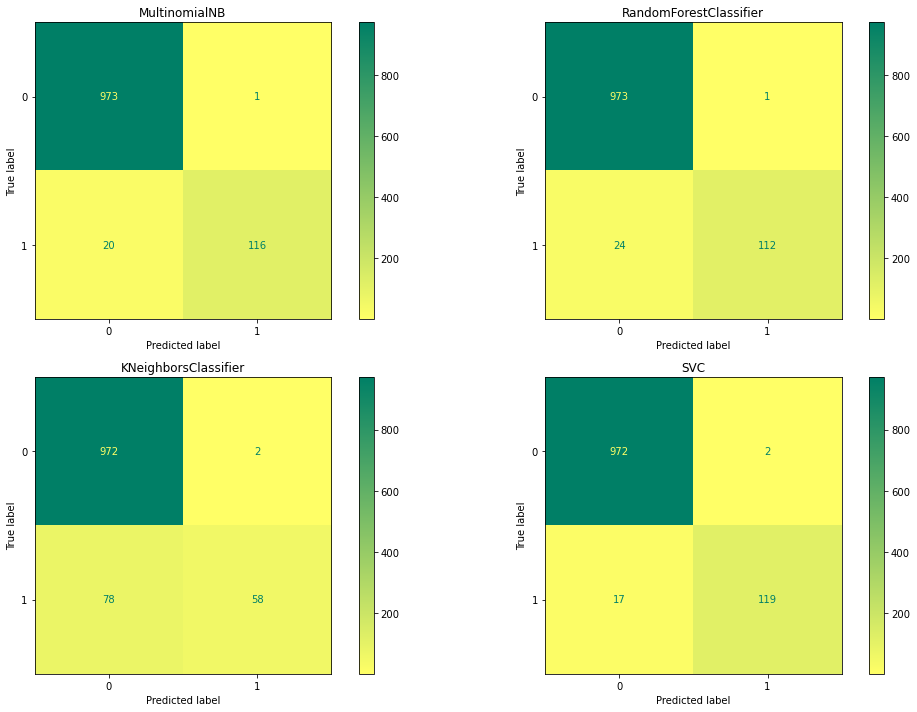

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap= 'summer_r')   
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()